# Libreries

In [ ]:
# Load libreries
from google.colab import drive
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import ImageOps, Image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.__version__

'2.5.0'

# Color information

In [ ]:
# From color_info.txt -> https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py#L52-L99

# Class names
names = ['unlabeled', 'dynamic', 'ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall',
         'fence', 'guard rail', 'bridge', 'tunnel', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
         'bus', 'caravan', 'trailer', 'train', 'motorcycle', 'bicycle', 'license plate']

# Class colors
colors = np.array([(0, 0, 0), (111, 74, 0), (81, 0, 81), (128, 64, 128), (244, 35, 232), (250, 170, 160), (230, 150, 140), (70, 70, 70), 
          (102, 102, 156), (190, 153, 153), (180, 165, 180), (150, 100, 100), (150, 120, 90), (153, 153, 153), (250, 170, 30), (220, 220, 0), (107, 142, 35), 
          (152, 251, 152), (70, 130, 180), (220, 20, 60), (255, 0, 0), ( 0, 0, 142), ( 0, 0, 70), (0, 60, 100), (0, 0, 90), (0, 0, 110), (0, 80, 100), (0, 0, 230), (119, 11, 32), 
          (0, 0, 142)], dtype = np.int32)

# Class info
pd.DataFrame({'Names': names, 'Colour': [col for col in colors]})

,Names,Colour
0,unlabeled,"[0, 0, 0]"
1,dynamic,"[111, 74, 0]"
2,ground,"[81, 0, 81]"
3,road,"[128, 64, 128]"
4,sidewalk,"[244, 35, 232]"
5,parking,"[250, 170, 160]"
6,rail track,"[230, 150, 140]"
7,building,"[70, 70, 70]"
8,wall,"[102, 102, 156]"
9,fence,"[190, 153, 153]"


# Load and preprocess

In [ ]:
# Define paths
train_images_folder_path = "/content/drive/My Drive/TFM/Train_data/Images"
train_mask_folder_path = "/content/drive/My Drive/TFM/Train_data/Labels"
val_images_folder_path = "/content/drive/My Drive/TFM/Validation_data/Images"
val_mask_folder_path = "/content/drive/My Drive/TFM/Validation_data/Labels"
#check_path = '/content/drive/My Drive/TFM/Data/Checkpoint'

# Get images and masks names
train_images_names = sorted([img for img in os.listdir(train_images_folder_path) if img.endswith('.png')])
train_mask_names = sorted([img for img in os.listdir(train_mask_folder_path) if img.endswith('.png')])
val_images_names = sorted([img for img in os.listdir(val_images_folder_path) if img.endswith('.png')])
val_mask_names = sorted([img for img in os.listdir(val_mask_folder_path) if img.endswith('.png')])

# Count
print(f'Train images: {len(train_images_names)}')
print(f'Train labels: {len(train_mask_names)}')
print(f'Validation images: {len(val_images_names)}')
print(f'Validation labels: {len(val_mask_names)}')

Train images: 2975
Train labels: 2975
Validation images: 500
Validation labels: 500


In [ ]:
# Define image shape. Images are 1024 x 2048 (height x width) so to maintain the relation: 
img_height, img_width = 128, 256

# One hot function with the colors
def one_hot_mask(y):
  one_hot_map = []
  for color in colors:
    class_map = tf.reduce_all(tf.equal(y, color), axis = -1)
    one_hot_map.append(class_map)
  mask = tf.cast(tf.stack(one_hot_map, axis = -1), tf.int32)
  return mask

# Load image, resize and normalize
def load_image_train(file, width, height, crop = True):
  image = tf.io.read_file(train_images_folder_path + '/' + file)
  image = tf.cast(tf.image.decode_png(image, channels = 3), tf.float32)
  if crop:
    image = tf.image.crop_to_bounding_box(image, 0, 0, 800, 2048)
  image = tf.image.resize(image, (height, width))
  image = tf.cast(image, tf.float32)/255.0
  return image

# Load mask, resize and one_hot
def load_mask_train(file, width, height, one_hot = True, crop = True):
  image = tf.io.read_file(train_mask_folder_path + '/' + file)
  image = tf.cast(tf.image.decode_png(image, channels = 3), tf.int32)
  if crop:
    image = tf.image.crop_to_bounding_box(image, 0, 0, 800, 2048)
  image = tf.image.resize(image, (height, width), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  if one_hot:
    image = one_hot_mask(image)
  return image

# Load image and mask together
def load(image_name, mask_name):
  image = load_image_train(image_name, img_width, img_height)
  mask = load_mask_train(mask_name, img_width, img_height)
  return image, mask

In [ ]:
# Check mask shape after one hot encoding
load_mask_train(train_mask_names[0], 256, 128).shape

TensorShape([128, 256, 30])

In [ ]:
# Create tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((train_images_names[:50], train_mask_names[:50]))
dataset = dataset.map(load, num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(32)
dataset

<BatchDataset shapes: ((None, 128, 256, 3), (None, 128, 256, 30)), types: (tf.float32, tf.int32)>

# Visualization

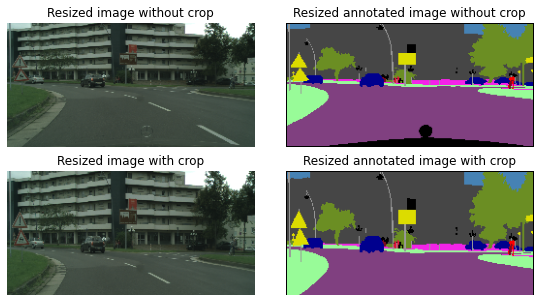

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (10, 5))
ax[0,0].imshow(load_image_train(train_images_names[0], img_width, img_height, crop = False))
ax[0,0].set_title('Resized image without crop')
ax[0,0].axis('off')

ax[0,1].imshow(load_mask_train(train_mask_names[0], img_width, img_height, one_hot = False, crop = False))
ax[0,1].set_title('Resized annotated image without crop')
ax[0,1].axis('off')

ax[1,0].imshow(load_image_train(train_images_names[0], img_width, img_height))
ax[1,0].set_title('Resized image with crop')
ax[1,0].axis('off')

ax[1,1].imshow(load_mask_train(train_mask_names[0], img_width, img_height, one_hot = False))
ax[1,1].set_title('Resized annotated image with crop')
ax[1,1].axis('off')

plt.subplots_adjust(wspace = 0)
plt.show()

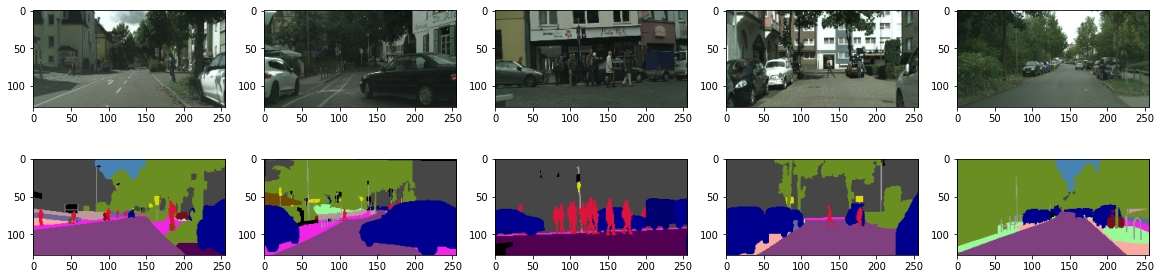

In [ ]:
# Plot 5 random images
idx = np.random.choice(len(train_images_names), 5)
plt.figure(figsize = (20, 5))
for i in range(5):
  plt.subplot(2, 5, i + 1)
  plt.imshow(load_image_train(train_images_names[idx[i]], img_width, img_height))
  plt.subplot(2, 5, i + 6)
  plt.imshow(load_mask_train(train_mask_names[idx[i]], img_width, img_height, one_hot = False))
plt.show()

# Check one hot

In [ ]:
prueba = load_mask_train(train_mask_names[0], 2, 2, one_hot = False)
prueba

<tf.Tensor: shape=(2, 2, 3), dtype=int32, numpy=
array([[[ 70,  70,  70],
        [ 70,  70,  70]],

       [[128,  64, 128],
        [128,  64, 128]]], dtype=int32)>

In [ ]:
one_hot_map = []
for color in colors[:5]:
  class_map = tf.reduce_all(tf.equal(prueba, color), axis = -1)
  one_hot_map.append(class_map)

In [ ]:
one_hot_map

[<tf.Tensor: shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [False, False]])>, <tf.Tensor: shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [False, False]])>, <tf.Tensor: shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [False, False]])>, <tf.Tensor: shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [ True,  True]])>, <tf.Tensor: shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [False, False]])>]

In [ ]:
mask = tf.cast(tf.stack(one_hot_map, axis = -1), tf.int32)
mask

<tf.Tensor: shape=(2, 2, 5), dtype=int32, numpy=
array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]]], dtype=int32)>

# NN without GDN

U-Net model without generalized division normalization.

In [ ]:
def conv_block(inputs, filters, pool = True):
    x = Conv2D(filters, 3, padding = "same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x


def build_unet(shape, num_classes):
    inputs = Input(shape)

    #Encoder
    x1, p1 = conv_block(inputs, 16, pool = True)
    x2, p2 = conv_block(p1, 32, pool = True)
    x3, p3 = conv_block(p2, 48, pool = True)
    x4, p4 = conv_block(p3, 64, pool = True)

    #Bridge
    b1 = conv_block(p4, 128, pool = False)

    #Decoder
    u1 = UpSampling2D((2, 2), interpolation = "bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool = False)

    u2 = UpSampling2D((2, 2), interpolation = "bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool = False)

    u3 = UpSampling2D((2, 2), interpolation = "bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool = False)

    u4 = UpSampling2D((2, 2), interpolation = "bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool = False)

    #Output
    output = Conv2D(num_classes, 1, padding = 'same', activation = 'softmax')(x8)

    return Model(inputs, output)

In [ ]:
# Build the model
model1 = build_unet((128, 256, 3), 30)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Train the model for a small number of epochs
lr = 1e-4
epochs = 10

model1.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = lr))

model1.fit(dataset, epochs = epochs)

Epoch 1/10
2/2 [==============================] - 64s 2s/step - loss: 3.7877
Epoch 2/10
2/2 [==============================] - 7s 2s/step - loss: 3.7169
Epoch 3/10
2/2 [==============================] - 6s 2s/step - loss: 3.6666
Epoch 4/10
2/2 [==============================] - 7s 2s/step - loss: 3.6229
Epoch 5/10
2/2 [==============================] - 6s 2s/step - loss: 3.5814
Epoch 6/10
2/2 [==============================] - 7s 2s/step - loss: 3.5422
Epoch 7/10
2/2 [==============================] - 7s 2s/step - loss: 3.5044
Epoch 8/10
2/2 [==============================] - 7s 2s/step - loss: 3.4664
Epoch 9/10
2/2 [==============================] - 6s 2s/step - loss: 3.4262
Epoch 10/10
2/2 [==============================] - 7s 2s/step - loss: 3.3843


# NN with GDN

U-Net model with generalized division normalization.

In [ ]:
!pip install tensorflow-compression

     |████████████████████████████████| 211 kB 8.3 MB/s 
     |████████████████████████████████| 28.5 MB 33 kB/s 
     |████████████████████████████████| 4.8 MB 57.6 MB/s 
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.13.0
    Uninstalling tensorflow-probability-0.13.0:
      Successfully uninstalled tensorflow-probability-0.13.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from tensorflow_compression import GDN

In [ ]:
def build_unet_gdn(shape, num_classes):
    inputs = Input(shape)

    #Encoder
    x1, p1 = conv_block(inputs, 16, pool = True)
    p1_1 = GDN()(p1)
    x2, p2 = conv_block(p1_1, 32, pool = True)
    p2_2 = GDN()(p2)
    x3, p3 = conv_block(p2_2, 48, pool = True)
    p3_3 = GDN()(p3)
    x4, p4 = conv_block(p3_3, 64, pool = True)

    #Bridge
    b1 = conv_block(p4, 128, pool = False)

    #Decoder
    u1 = UpSampling2D((2, 2), interpolation = "bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool = False)

    u2 = UpSampling2D((2, 2), interpolation = "bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool = False)

    u3 = UpSampling2D((2, 2), interpolation = "bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool = False)

    u4 = UpSampling2D((2, 2), interpolation = "bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool = False)

    #Output
    output = Conv2D(num_classes, 1, padding = 'same', activation = 'softmax')(x8)

    return Model(inputs, output)

# Build the model
model_2 = build_unet_gdn((128, 256, 3), 30)
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128, 256, 16) 64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 128, 256, 16) 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [ ]:
# Train the model for a small number of epochs
lr = 1e-4
epochs = 10

model_2.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = lr))

model_2.fit(dataset, epochs = epochs)

Epoch 1/10
2/2 [==============================] - 11s 2s/step - loss: 3.7782
Epoch 2/10
2/2 [==============================] - 7s 2s/step - loss: 3.6861
Epoch 3/10
2/2 [==============================] - 7s 2s/step - loss: 3.6269
Epoch 4/10
2/2 [==============================] - 6s 2s/step - loss: 3.5792
Epoch 5/10
2/2 [==============================] - 6s 2s/step - loss: 3.5374
Epoch 6/10
2/2 [==============================] - 6s 2s/step - loss: 3.4990
Epoch 7/10
2/2 [==============================] - 7s 1s/step - loss: 3.4643
Epoch 8/10
2/2 [==============================] - 7s 2s/step - loss: 3.4329
Epoch 9/10
2/2 [==============================] - 7s 2s/step - loss: 3.4043
Epoch 10/10
2/2 [==============================] - 7s 2s/step - loss: 3.3773
